# Ride Pricing & Surge Modeling for Urban Mobility


In [3]:
import pandas as pd 
import numpy as np 


import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, sqrt, atan2

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor, XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import shap



import warnings 
warnings.filterwarnings("ignore")

# **01-Data Understanding**

In [4]:
cab_data = pd.read_csv('cab_rides.csv')
weather_data = pd.read_csv('weather.csv')

In [5]:
cab_data.head()


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [6]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [7]:
cab_data.info()
print("-"*50)
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp  

# **Data Preparation**

## *Cab_rides*

### Feature Understanding 

In [8]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


price (Target Variable)

The price feature represents the estimated cost of a cab ride.<br>
the distribution is right-skewed, with most prices concentrated in lower ranges and a small number of <br>
high-priced rides. Around 8% of the values are missing and will need to be handle carefully during preprocessing



In [9]:
cab_data['price'].describe()

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [10]:
cab_data['price'].isnull().mean()

np.float64(0.07949402009317949)

<Axes: >

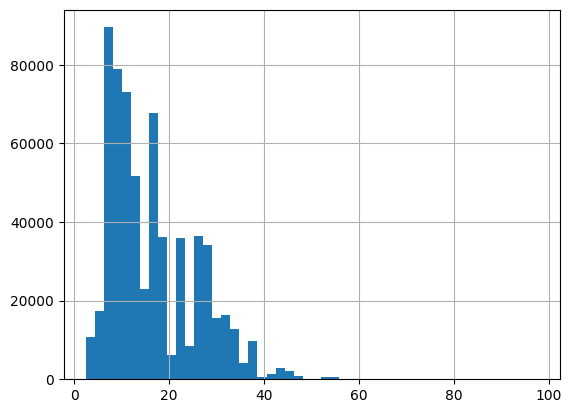

In [11]:
cab_data['price'].hist(bins=50)

# right skewed distribution


time_stamp

The time_stamp feature represents the time at which the ride price was queried,<br>
stored as a Unix timestamp in milliseconds. The values fall within a narrow temoral range, <br>
indicating that the data was collected over a limited period. There are no missing <br>
value, makeing theis feature reliable for tempral analysis after conversion.


In [12]:
cab_data['time_stamp'].describe()

count    6.930710e+05
mean     1.544046e+12
std      6.891925e+08
min      1.543204e+12
25%      1.543444e+12
50%      1.543737e+12
75%      1.544828e+12
max      1.545161e+12
Name: time_stamp, dtype: float64

In [13]:
cab_data['time_stamp'].head()


0    1544952607890
1    1543284023677
2    1543366822198
3    1543553582749
4    1543463360223
Name: time_stamp, dtype: int64

cab_type

The cab_type feature distinguishes between Uber and Lyft rides. The analysis shows that
Lyft rides have a higher average price compared to Uber, despite Uber having a larger
number of ride records. This indicates platform-specific pricing strategies, making this
feature important for explaining price variation.


In [14]:
cab_data.groupby('cab_type')['price'].mean()

cab_type
Lyft    17.351396
Uber    15.795343
Name: price, dtype: float64

In [15]:
cab_data['cab_type'].value_counts()

cab_type
Uber    385663
Lyft    307408
Name: count, dtype: int64

distance 

the distance feature showsa moderate positive correlation with ride price, indicating<br>
that longer trips generally cost more. however the scatter plot reveals significant<br>
price variation for similar distances, suggesting that factors beyond distance, such as<br>
demand and service type, also play a major role in pricing.


In [16]:
cab_data[['distance','price']].corr()

,distance,price
distance,1.000000,0.345061
price,0.345061,1.000000


<Axes: xlabel='distance', ylabel='price'>

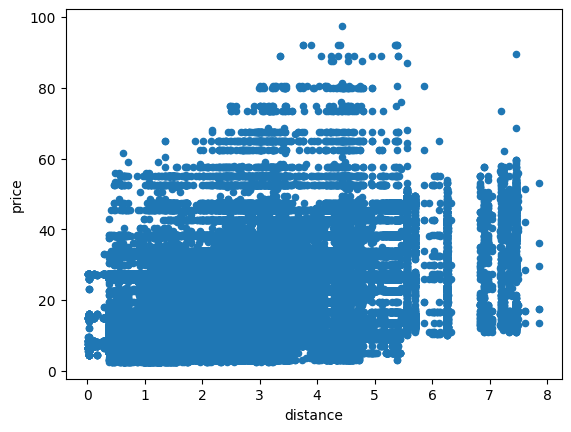

In [17]:
cab_data.plot.scatter(x='distance',y='price', alpha=1)

surge_multiplier

The surge_multiplier feature shows a very strong and direct relationship with ride price
, as it represents the surge priceing factor applied during high demand periods.
most rides occur with no surge (multipler = 1.0) while higher surge values are rare but
associated with significantly increase prices, Due to its direct invovement in price0
calculation, this feature must be handle carefully to avoid date leakage during  modling

<p style=color:#C66E52>Surge_multiplier is part of the price calculation itself. Using it to predict price <br> would leak information from the target </p>

In [18]:
cab_data.groupby('surge_multiplier')['price'].mean().head(10)

surge_multiplier
1.00    16.161259
1.25    23.768471
1.50    28.894472
1.75    33.673760
2.00    39.048459
2.50    30.207792
3.00    40.333333
Name: price, dtype: float64

In [19]:
cab_data['surge_multiplier'].value_counts().head(10)

surge_multiplier
1.00    672096
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: count, dtype: int64

name

The service type shows a clear stratification in ride prices , with shared service the cheapest and luxury services the most expensive, This indicates thatservice type is a strong determinant of price and captures different pricing tiers effectively 

In [20]:
cab_data.groupby('name')['price'].mean().sort_values()


name
Shared           6.029893
UberPool         8.752500
Lyft             9.610885
WAV              9.765019
UberX            9.765074
Lyft XL         15.309363
UberXL          15.678144
Lux             17.771240
Black           20.523786
Lux Black       23.062468
Black SUV       30.286763
Lux Black XL    32.324086
Taxi                  NaN
Name: price, dtype: float64

In [21]:
cab_data['name'].value_counts()

name
UberXL          55096
WAV             55096
Black SUV       55096
Black           55095
Taxi            55095
UberX           55094
UberPool        55091
Lux             51235
Lux Black XL    51235
Lyft            51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: count, dtype: int64

source

The results are sorted in descending order (ascending=False), meaning locations with
higher average prices appear first.


In [22]:
cab_data['source'].value_counts().head(10)

source
Financial District         58857
Theatre District           57813
Back Bay                   57792
Boston University          57764
North End                  57763
Fenway                     57757
Northeastern University    57756
South Station              57750
Haymarket Square           57736
West End                   57562
Name: count, dtype: int64

In [23]:
cab_data.groupby('source')['price'].mean().sort_values(ascending=False)

source
Boston University          18.853034
Fenway                     18.379491
Financial District         18.181372
Northeastern University    17.901124
Theatre District           16.596994
North Station              16.364006
West End                   16.108498
Back Bay                   16.047394
South Station              15.672479
Beacon Hill                15.664030
North End                  15.153373
Haymarket Square           13.578114
Name: price, dtype: float64

### PreCleaning Exploration 

In [24]:
cab_data.isnull().mean().sort_values(ascending=False)

# the only feature containing missing value is price , with approximately 8%

price               0.079494
distance            0.000000
cab_type            0.000000
time_stamp          0.000000
destination         0.000000
source              0.000000
surge_multiplier    0.000000
id                  0.000000
product_id          0.000000
name                0.000000
dtype: float64

In [25]:
cab_data['price'].describe()

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

In [26]:
cab_data[cab_data['price'] <= 0]


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name


In [27]:
cab_data['distance'].describe()

count    693071.000000
mean          2.189430
std           1.138937
min           0.020000
25%           1.280000
50%           2.160000
75%           2.920000
max           7.860000
Name: distance, dtype: float64

In [28]:
cab_data[cab_data['distance'] <= 0]


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name


In [29]:
cab_data['cab_type'].unique()
cab_data['name'].unique()


array(['Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black',
       'UberXL', 'Black', 'UberX', 'WAV', 'Black SUV', 'UberPool', 'Taxi'],
      dtype=object)

In [30]:
cab_data['name'].value_counts(normalize=True)


name
UberXL          0.079495
WAV             0.079495
Black SUV       0.079495
Black           0.079494
Taxi            0.079494
UberX           0.079493
UberPool        0.079488
Lux             0.073925
Lux Black XL    0.073925
Lyft            0.073925
Lyft XL         0.073925
Lux Black       0.073925
Shared          0.073922
Name: proportion, dtype: float64

In [31]:
cab_data['time_stamp'].min(), cab_data['time_stamp'].max()

# is value in unix format

(np.int64(1543203646318), np.int64(1545160510943))

In [32]:
cab_clean = cab_data.copy()

In [33]:
cab_clean = cab_clean.drop(['id', 'product_id'], axis=1, errors='ignore')


In [34]:
cab_clean = cab_clean.dropna(subset=['price'])

In [35]:
cab_clean['datetime'] = pd.to_datetime(cab_clean['time_stamp'], unit='ms')

In [36]:
cab_clean = cab_clean[[
    'datetime', 'time_stamp', 'cab_type', 'name',
     'source', 'destination', 'distance',
     'surge_multiplier', 'price'
]]

In [37]:
cab_clean

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price
0,2018-12-16 09:30:07.890,1544952607890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0
1,2018-11-27 02:00:23.677,1543284023677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0
2,2018-11-28 01:00:22.198,1543366822198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0
3,2018-11-30 04:53:02.749,1543553582749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0
4,2018-11-29 03:49:20.223,1543463360223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0
...,...,...,...,...,...,...,...,...,...
693065,2018-12-01 23:53:05.534,1543708385534,Uber,WAV,West End,North End,1.00,1.0,9.5
693066,2018-12-01 23:53:05.534,1543708385534,Uber,UberXL,West End,North End,1.00,1.0,13.0
693067,2018-12-01 23:53:05.534,1543708385534,Uber,UberX,West End,North End,1.00,1.0,9.5
693069,2018-12-01 23:53:05.534,1543708385534,Uber,Black SUV,West End,North End,1.00,1.0,27.0


### Time Alignment 


 Cab Data Time Alignment

Cab ride observations were aggregated to an hourly level by flooring timestamps to the
start of each hour. For each hour, summary statistics such as average price, average
distance, average surge multiplier, and total ride count were computed. This results in
a time-aligned dataset suitable for integration with hourly weather data.


In [38]:
cab_clean

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price
0,2018-12-16 09:30:07.890,1544952607890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0
1,2018-11-27 02:00:23.677,1543284023677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0
2,2018-11-28 01:00:22.198,1543366822198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0
3,2018-11-30 04:53:02.749,1543553582749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0
4,2018-11-29 03:49:20.223,1543463360223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0
...,...,...,...,...,...,...,...,...,...
693065,2018-12-01 23:53:05.534,1543708385534,Uber,WAV,West End,North End,1.00,1.0,9.5
693066,2018-12-01 23:53:05.534,1543708385534,Uber,UberXL,West End,North End,1.00,1.0,13.0
693067,2018-12-01 23:53:05.534,1543708385534,Uber,UberX,West End,North End,1.00,1.0,9.5
693069,2018-12-01 23:53:05.534,1543708385534,Uber,Black SUV,West End,North End,1.00,1.0,27.0


In [39]:
cab_clean['hour'] = cab_clean['datetime'].dt.floor('H')

In [40]:
cab_hourly = cab_clean.groupby('hour').agg(avg_price=('price', 'mean'),
                                           avg_distance=('distance', 'mean'),
                                           avg_surge=('surge_multiplier', 'mean'),
                                             ride_count=('price', 'count')).reset_index()

In [41]:
cab_clean

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price,hour
0,2018-12-16 09:30:07.890,1544952607890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0,2018-12-16 09:00:00
1,2018-11-27 02:00:23.677,1543284023677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0,2018-11-27 02:00:00
2,2018-11-28 01:00:22.198,1543366822198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0,2018-11-28 01:00:00
3,2018-11-30 04:53:02.749,1543553582749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0,2018-11-30 04:00:00
4,2018-11-29 03:49:20.223,1543463360223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0,2018-11-29 03:00:00
...,...,...,...,...,...,...,...,...,...,...
693065,2018-12-01 23:53:05.534,1543708385534,Uber,WAV,West End,North End,1.00,1.0,9.5,2018-12-01 23:00:00
693066,2018-12-01 23:53:05.534,1543708385534,Uber,UberXL,West End,North End,1.00,1.0,13.0,2018-12-01 23:00:00
693067,2018-12-01 23:53:05.534,1543708385534,Uber,UberX,West End,North End,1.00,1.0,9.5,2018-12-01 23:00:00
693069,2018-12-01 23:53:05.534,1543708385534,Uber,Black SUV,West End,North End,1.00,1.0,27.0,2018-12-01 23:00:00


In [42]:
cab_hourly.head()

,hour,avg_price,avg_distance,avg_surge,ride_count
0,2018-11-26 03:00:00,18.694805,2.513896,1.032468,77
1,2018-11-26 04:00:00,16.537179,2.179359,1.014103,390
2,2018-11-26 05:00:00,16.482955,2.219773,1.017451,616
3,2018-11-26 06:00:00,16.525992,2.154118,1.018468,1462
4,2018-11-26 07:00:00,16.249730,2.135362,1.008919,925


In [43]:

cab_hourly.shape


(332, 5)

## *Weather*

### Feature Understanding

In [44]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [45]:
weather_data.shape

(6276, 8)

temp
<br>

Represents air temerature. The values are within a reasonable range and show a stable distribution. Temerature is expected in influence eidedemand,<br> especially 
during colder conditions. 

In [46]:
weather_data['temp'].describe()

count    6276.000000
mean       39.090475
std         6.022055
min        19.620000
25%        36.077500
50%        40.130000
75%        42.832500
max        55.410000
Name: temp, dtype: float64

<Axes: >

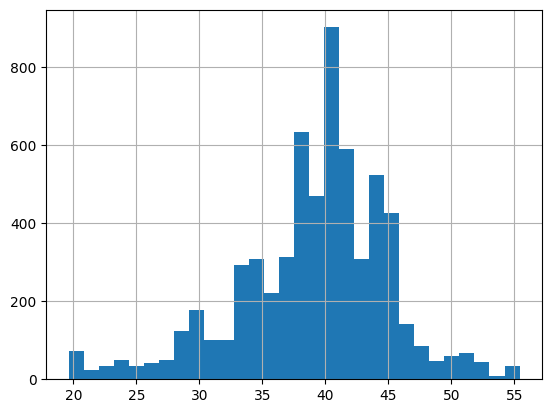

In [47]:
weather_data['temp'].hist(bins=30)

rain 
<br>
shows how much rain falls in a given time . Most of the time there is no rain , 
but when rain occurs it can strongly increase ride demand and prices

In [48]:
weather_data['rain'].describe()

count    894.000000
mean       0.057652
std        0.100758
min        0.000200
25%        0.004900
50%        0.014850
75%        0.060925
max        0.780700
Name: rain, dtype: float64

<Axes: >

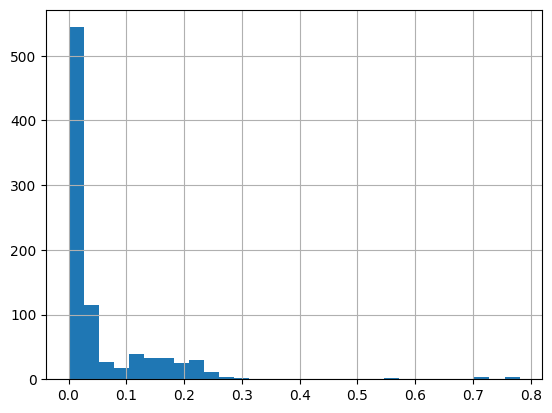

In [49]:
weather_data['rain'].hist(bins=30)

In [50]:
(weather_data['rain'] > 0).mean()  

np.float64(0.14244741873804972)

clouds
<br>
Shows how cloudy the sky is, with values between 0 and 1. Most observations
have high cloud coverage, which may slightly increase ride demand.


In [51]:
weather_data['clouds'].value_counts()

clouds
1.00    1100
0.99     224
0.98     192
0.97     190
0.92     135
        ... 
0.23      12
0.66      10
0.30       6
0.02       4
0.10       4
Name: count, Length: 100, dtype: int64

<Axes: >

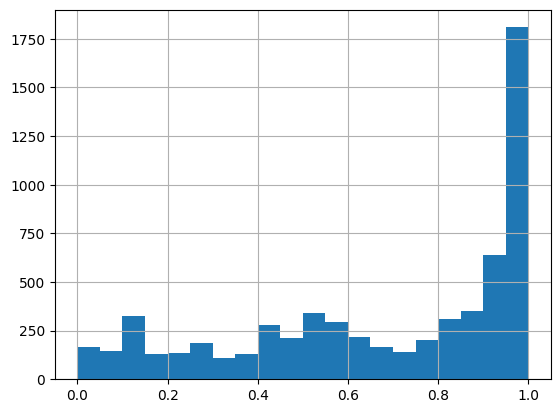

In [52]:
weather_data['clouds'].hist(bins=20)

# left skewed distribution

humidity 
<br>
Shows how humid the air is . Most values are relatively high , which can 
reduce comfort and slightly increase ride demand.

In [53]:
weather_data['humidity'].describe()

count    6276.000000
mean        0.763985
std         0.127340
min         0.450000
25%         0.670000
50%         0.760000
75%         0.890000
max         0.990000
Name: humidity, dtype: float64

<Axes: >

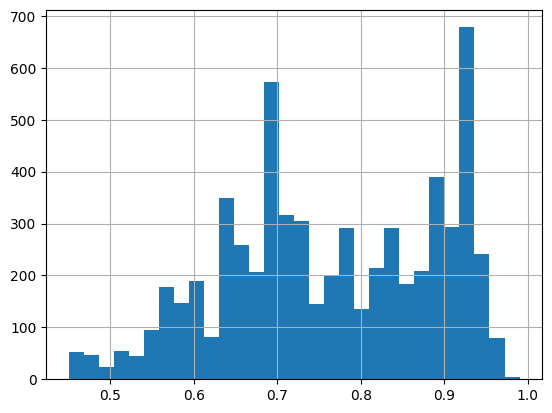

In [54]:
weather_data['humidity'].hist(bins=30)

**pressure:** Represents air pressure. Values are within a normal range and change with
weather conditions. Its effect on ride demand is indirect.


In [55]:
weather_data['pressure'].describe()

count    6276.000000
mean     1008.445209
std        12.870775
min       988.250000
25%       997.747500
50%      1007.660000
75%      1018.480000
max      1035.120000
Name: pressure, dtype: float64

<Axes: >

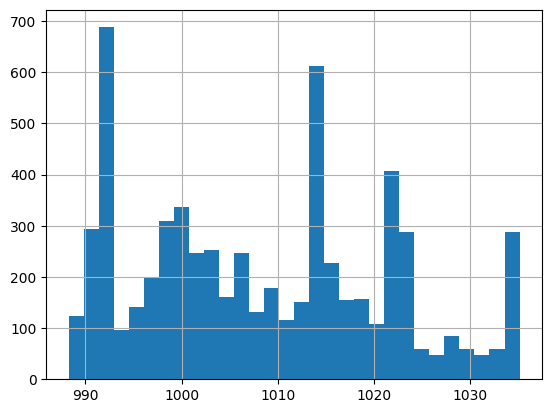

In [56]:
weather_data['pressure'].hist(bins=30)

In [57]:
weather_data['location'].value_counts()


location
Back Bay                   523
Beacon Hill                523
Boston University          523
Fenway                     523
Financial District         523
Haymarket Square           523
North End                  523
North Station              523
Northeastern University    523
South Station              523
Theatre District           523
West End                   523
Name: count, dtype: int64

**time_stamp:** Represents the time of weather observation in Unix format. Values are
clean, continuous, and repeated across locations, which is expected for hourly weather data.


In [58]:
weather_data['time_stamp'].describe()



count    6.276000e+03
mean     1.543857e+09
std      6.659340e+05
min      1.543204e+09
25%      1.543387e+09
50%      1.543514e+09
75%      1.544691e+09
max      1.545159e+09
Name: time_stamp, dtype: float64

In [59]:
weather_data['time_stamp'].head()

0    1545003901
1    1545003901
2    1545003901
3    1545003901
4    1545003901
Name: time_stamp, dtype: int64

### PreCleaning Exploration

In [60]:
weather_data.isnull().mean().sort_values(ascending=False)

rain          0.857553
temp          0.000000
clouds        0.000000
location      0.000000
pressure      0.000000
time_stamp    0.000000
humidity      0.000000
wind          0.000000
dtype: float64

In [61]:
weather_data[weather_data['temp'] <= 0]

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind


In [62]:
weather_data[(weather_data['humidity'] < 0) | (weather_data['humidity'] > 1)]


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind


In [63]:
weather_data[weather_data['rain'] < 0]


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind


In [64]:
weather_data[(weather_data['clouds'] < 0) | (weather_data['clouds'] > 1)]


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind


In [65]:
weather_data[weather_data['wind'] < 0]


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind


In [66]:
weather_data.duplicated().mean()


np.float64(0.0)

### Data Cleaning

In [67]:
weather_clean = weather_data.copy()

In [68]:
weather_clean['rain'] = weather_clean['rain'].fillna(0)

In [69]:
weather_clean.isnull().mean()


temp          0.0
location      0.0
clouds        0.0
pressure      0.0
rain          0.0
time_stamp    0.0
humidity      0.0
wind          0.0
dtype: float64

In [70]:
weather_clean['datetime'] = pd.to_datetime(weather_clean['time_stamp'], unit='s')

In [71]:
weather_clean = weather_clean[['datetime', 'time_stamp', 'location', 'temp', 'rain',
     'clouds', 'humidity', 'wind', 'pressure']]

In [72]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6276 non-null   datetime64[ns]
 1   time_stamp  6276 non-null   int64         
 2   location    6276 non-null   object        
 3   temp        6276 non-null   float64       
 4   rain        6276 non-null   float64       
 5   clouds      6276 non-null   float64       
 6   humidity    6276 non-null   float64       
 7   wind        6276 non-null   float64       
 8   pressure    6276 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 441.4+ KB


In [73]:

weather_clean.head()

,datetime,time_stamp,location,temp,rain,clouds,humidity,wind,pressure
0,2018-12-16 23:45:01,1545003901,Back Bay,42.42,0.1228,1.0,0.77,11.25,1012.14
1,2018-12-16 23:45:01,1545003901,Beacon Hill,42.43,0.1846,1.0,0.76,11.32,1012.15
2,2018-12-16 23:45:01,1545003901,Boston University,42.50,0.1089,1.0,0.76,11.07,1012.15
3,2018-12-16 23:45:01,1545003901,Fenway,42.11,0.0969,1.0,0.77,11.09,1012.13
4,2018-12-16 23:45:01,1545003901,Financial District,43.13,0.1786,1.0,0.75,11.49,1012.14


### Time Alignment

In [74]:
weather_clean['hour'] = weather_clean['datetime'].dt.floor('H') 

In [75]:
weather_clean[['datetime', 'hour']].head()


,datetime,hour
0,2018-12-16 23:45:01,2018-12-16 23:00:00
1,2018-12-16 23:45:01,2018-12-16 23:00:00
2,2018-12-16 23:45:01,2018-12-16 23:00:00
3,2018-12-16 23:45:01,2018-12-16 23:00:00
4,2018-12-16 23:45:01,2018-12-16 23:00:00


In [76]:
weather_hourly = (
    weather_clean
    .groupby('hour')
    .agg(
        avg_temp=('temp', 'mean'),
        avg_rain=('rain', 'mean'),
        avg_clouds=('clouds', 'mean'),
        avg_humidity=('humidity', 'mean'),
        avg_wind=('wind', 'mean'),
        avg_pressure=('pressure', 'mean')
    )
    .reset_index()
)


In [77]:
weather_hourly.head()

,hour,avg_temp,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure
0,2018-11-26 03:00:00,40.930833,0.0,0.875000,0.925000,1.478333,1014.379167
1,2018-11-26 04:00:00,40.569500,0.0,0.895000,0.928500,2.649833,1014.006333
2,2018-11-26 05:00:00,40.494687,0.0,0.930938,0.924375,2.501979,1013.825729
3,2018-11-26 06:00:00,40.742556,0.0,0.990667,0.912222,1.373778,1014.200056
4,2018-11-26 07:00:00,41.312917,0.0,0.963125,0.918958,1.821042,1014.282708


In [78]:
weather_hourly.shape

(330, 7)

## **Merge**

In [79]:
cab_clean[['hour']].head(10)

,hour
0,2018-12-16 09:00:00
1,2018-11-27 02:00:00
2,2018-11-28 01:00:00
3,2018-11-30 04:00:00
4,2018-11-29 03:00:00
5,2018-12-17 18:00:00
6,2018-11-26 05:00:00
7,2018-12-02 19:00:00
8,2018-12-03 06:00:00
9,2018-11-27 10:00:00


In [80]:
cab_hourly[['hour']].head(10)

,hour
0,2018-11-26 03:00:00
1,2018-11-26 04:00:00
2,2018-11-26 05:00:00
3,2018-11-26 06:00:00
4,2018-11-26 07:00:00
5,2018-11-26 08:00:00
6,2018-11-26 09:00:00
7,2018-11-26 10:00:00
8,2018-11-26 11:00:00
9,2018-11-26 12:00:00


In [81]:
cab_clean['hour'].dtype, weather_hourly['hour'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [82]:
cab_weather = cab_clean.merge(
    weather_hourly,
    on='hour',
    how='left'
)

In [83]:
cab_weather.shape

(637976, 16)

In [84]:
cab_weather.head()

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price,hour,avg_temp,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure
0,2018-12-16 09:30:07.890,1544952607890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0,2018-12-16 09:00:00,38.610833,0.000000,0.284167,0.755833,7.811667,1022.380833
1,2018-11-27 02:00:23.677,1543284023677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0,2018-11-27 02:00:00,44.054167,0.134792,0.995000,0.898333,12.536250,1002.855417
2,2018-11-28 01:00:22.198,1543366822198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0,2018-11-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-11-30 04:53:02.749,1543553582749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0,2018-11-30 04:00:00,34.695000,0.000000,0.000000,0.712500,5.208333,1013.710000
4,2018-11-29 03:49:20.223,1543463360223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0,2018-11-29 03:00:00,38.011944,0.000000,0.430278,0.698889,11.085278,998.428889


# **Feature Engineer**

### • Geospatial processing of pickup/dropoff coordinates

In [85]:
location_coords = {
    'Haymarket Square': (42.3638, -71.0589),
    'Back Bay': (42.3503, -71.0810),
    'North Station': (42.3656, -71.0616),
    'South Station': (42.3522, -71.0552),
    'Fenway': (42.3467, -71.0972),
    'Financial District': (42.3555, -71.0565),
    'Beacon Hill': (42.3588, -71.0707),
    'West End': (42.3645, -71.0631)
}


In [86]:
cab_weather['pickup_lat'] = cab_weather['source'].map(
    lambda x: location_coords.get(x, (np.nan, np.nan))[0]
)
cab_weather['pickup_lon'] = cab_weather['source'].map(
    lambda x: location_coords.get(x, (np.nan, np.nan))[1]
)

cab_weather['dropoff_lat'] = cab_weather['destination'].map(
    lambda x: location_coords.get(x, (np.nan, np.nan))[0]
)
cab_weather['dropoff_lon'] = cab_weather['destination'].map(
    lambda x: location_coords.get(x, (np.nan, np.nan))[1]
)


### • Engineer distance features using Haversine formula 

In [87]:
# calculate haversine distance

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])  # convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2  # Haversine formula

    c = 2 * atan2(sqrt(a), sqrt(1 - a))# calculate the distance

    return R * c # distance in kilometers


In [88]:
cab_weather['geo_distance_km'] = cab_weather.apply(
    lambda row: haversine(
        row['pickup_lat'], row['pickup_lon'],
        row['dropoff_lat'], row['dropoff_lon']
    ),
    axis=1
)

In [89]:
cab_weather.head()

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price,hour,...,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,geo_distance_km
0,2018-12-16 09:30:07.890,1544952607890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0,2018-12-16 09:00:00,...,0.000000,0.284167,0.755833,7.811667,1022.380833,42.3638,-71.0589,42.3656,-71.0616,0.298778
1,2018-11-27 02:00:23.677,1543284023677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0,2018-11-27 02:00:00,...,0.134792,0.995000,0.898333,12.536250,1002.855417,42.3638,-71.0589,42.3656,-71.0616,0.298778
2,2018-11-28 01:00:22.198,1543366822198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0,2018-11-28 01:00:00,...,NaN,NaN,NaN,NaN,NaN,42.3638,-71.0589,42.3656,-71.0616,0.298778
3,2018-11-30 04:53:02.749,1543553582749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0,2018-11-30 04:00:00,...,0.000000,0.000000,0.712500,5.208333,1013.710000,42.3638,-71.0589,42.3656,-71.0616,0.298778
4,2018-11-29 03:49:20.223,1543463360223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0,2018-11-29 03:00:00,...,0.000000,0.430278,0.698889,11.085278,998.428889,42.3638,-71.0589,42.3656,-71.0616,0.298778


In [90]:
cab_weather.columns

Index(['datetime', 'time_stamp', 'cab_type', 'name', 'source', 'destination',
       'distance', 'surge_multiplier', 'price', 'hour', 'avg_temp', 'avg_rain',
       'avg_clouds', 'avg_humidity', 'avg_wind', 'avg_pressure', 'pickup_lat',
       'pickup_lon', 'dropoff_lat', 'dropoff_lon', 'geo_distance_km'],
      dtype='object')

### • Create temporal features: rush hour indicators, holiday effects 

In [91]:
cab_weather['time_stamp'] = pd.to_datetime(
    cab_weather['time_stamp'], unit='ms'
)

cab_weather['year'] = cab_weather['time_stamp'].dt.year
cab_weather['month'] = cab_weather['time_stamp'].dt.month
cab_weather['day'] = cab_weather['time_stamp'].dt.day
cab_weather['day_of_week'] = cab_weather['time_stamp'].dt.dayofweek
cab_weather['hour'] = cab_weather['time_stamp'].dt.hour

cab_weather['is_rushhour'] = cab_weather['hour'].isin(
    [7,8,9,16,17,18,19]
).astype(int)

cab_weather['is_weekend'] = cab_weather['day_of_week'].isin([5,6]).astype(int)


In [92]:
pd.set_option('display.max_columns', None )

In [93]:
cab_weather.head()

,datetime,time_stamp,cab_type,name,source,destination,distance,surge_multiplier,price,hour,avg_temp,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,geo_distance_km,year,month,day,day_of_week,is_rushhour,is_weekend
0,2018-12-16 09:30:07.890,2018-12-16 09:30:07.890,Lyft,Shared,Haymarket Square,North Station,0.44,1.0,5.0,9,38.610833,0.000000,0.284167,0.755833,7.811667,1022.380833,42.3638,-71.0589,42.3656,-71.0616,0.298778,2018,12,16,6,1,1
1,2018-11-27 02:00:23.677,2018-11-27 02:00:23.677,Lyft,Lux,Haymarket Square,North Station,0.44,1.0,11.0,2,44.054167,0.134792,0.995000,0.898333,12.536250,1002.855417,42.3638,-71.0589,42.3656,-71.0616,0.298778,2018,11,27,1,0,0
2,2018-11-28 01:00:22.198,2018-11-28 01:00:22.198,Lyft,Lyft,Haymarket Square,North Station,0.44,1.0,7.0,1,NaN,NaN,NaN,NaN,NaN,NaN,42.3638,-71.0589,42.3656,-71.0616,0.298778,2018,11,28,2,0,0
3,2018-11-30 04:53:02.749,2018-11-30 04:53:02.749,Lyft,Lux Black XL,Haymarket Square,North Station,0.44,1.0,26.0,4,34.695000,0.000000,0.000000,0.712500,5.208333,1013.710000,42.3638,-71.0589,42.3656,-71.0616,0.298778,2018,11,30,4,0,0
4,2018-11-29 03:49:20.223,2018-11-29 03:49:20.223,Lyft,Lyft XL,Haymarket Square,North Station,0.44,1.0,9.0,3,38.011944,0.000000,0.430278,0.698889,11.085278,998.428889,42.3638,-71.0589,42.3656,-71.0616,0.298778,2018,11,29,3,0,0


# **Preprocessing** 

In [94]:
cab_weather.isnull().mean().sort_values(ascending=False)

geo_distance_km     0.582752
pickup_lon          0.333411
pickup_lat          0.333411
dropoff_lat         0.333381
dropoff_lon         0.333381
avg_humidity        0.004285
avg_wind            0.004285
avg_rain            0.004285
avg_temp            0.004285
avg_clouds          0.004285
avg_pressure        0.004285
hour                0.000000
price               0.000000
surge_multiplier    0.000000
distance            0.000000
source              0.000000
destination         0.000000
name                0.000000
cab_type            0.000000
datetime            0.000000
time_stamp          0.000000
year                0.000000
month               0.000000
day                 0.000000
day_of_week         0.000000
is_rushhour         0.000000
is_weekend          0.000000
dtype: float64

In [95]:
drop_cols = [
    'geo_distance_km', 'pickup_lat', 'pickup_lon', 'dropoff_lat', 'dropoff_lon','datetime', 'time_stamp'
]

cab_weather = cab_weather.drop(columns=drop_cols, errors='ignore')

In [96]:
cab_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637976 entries, 0 to 637975
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cab_type          637976 non-null  object 
 1   name              637976 non-null  object 
 2   source            637976 non-null  object 
 3   destination       637976 non-null  object 
 4   distance          637976 non-null  float64
 5   surge_multiplier  637976 non-null  float64
 6   price             637976 non-null  float64
 7   hour              637976 non-null  int32  
 8   avg_temp          635242 non-null  float64
 9   avg_rain          635242 non-null  float64
 10  avg_clouds        635242 non-null  float64
 11  avg_humidity      635242 non-null  float64
 12  avg_wind          635242 non-null  float64
 13  avg_pressure      635242 non-null  float64
 14  year              637976 non-null  int32  
 15  month             637976 non-null  int32  
 16  day               63

In [97]:
cat_cols = ['cab_type', 'name', 'source', 'destination']

In [98]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
encoded = ohe.fit_transform(cab_weather[['cab_type', 'name']])

encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(['cab_type', 'name'])
)

cab_weather = pd.concat(
    [cab_weather.drop(columns=['cab_type', 'name']), encoded_df],
    axis=1
)

In [99]:
source_freq = cab_weather['source'].value_counts(normalize=True)
cab_weather['source_freq'] = cab_weather['source'].map(source_freq)


In [100]:
dest_freq = cab_weather['destination'].value_counts(normalize=True)
cab_weather['destination_freq'] = cab_weather['destination'].map(dest_freq)


In [101]:
cab_weather = cab_weather.drop(columns=['source', 'destination'])


In [102]:
cab_weather.head()

,distance,surge_multiplier,price,hour,avg_temp,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure,year,month,day,day_of_week,is_rushhour,is_weekend,cab_type_Uber,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,source_freq,destination_freq
0,0.44,1.0,5.0,9,38.610833,0.000000,0.284167,0.755833,7.811667,1022.380833,2018,12,16,6,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.083306,0.082412
1,0.44,1.0,11.0,2,44.054167,0.134792,0.995000,0.898333,12.536250,1002.855417,2018,11,27,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
2,0.44,1.0,7.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2018,11,28,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
3,0.44,1.0,26.0,4,34.695000,0.000000,0.000000,0.712500,5.208333,1013.710000,2018,11,30,4,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
4,0.44,1.0,9.0,3,38.011944,0.000000,0.430278,0.698889,11.085278,998.428889,2018,11,29,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412


**split data without surge_multiplier and another data with surge multiplier for EDA**

In [103]:
x = cab_weather.drop(
    columns=['price', 'surge_multiplier']
)

y = cab_weather['price']


In [104]:
x_with_surge = cab_weather.drop(columns=['price'])


In [105]:
x_temp, x_test, y_temp, y_test = train_test_split( x, y, test_size=0.3, random_state=42)

In [106]:
x_train, x_val, y_train, y_val = train_test_split( x_temp , y_temp , test_size=0.5, random_state=42 )


**Scaling**

In [107]:
num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_val[num_cols]   = scaler.transform(x_val[num_cols])
x_test[num_cols]  = scaler.transform(x_test[num_cols])


# **Baseline Model**

The baseline model achieved an MAE of 7.56 and an RMSE of 9.34 by predicting the mean
training price for all test samples. These values serve as a minimum performance
benchmark for subsequent models.


In [108]:
from sklearn.impute import SimpleImputer

num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns

imputer = SimpleImputer(strategy='mean')

x_train[num_cols] = imputer.fit_transform(x_train[num_cols])
x_val[num_cols]   = imputer.transform(x_val[num_cols])
x_test[num_cols]  = imputer.transform(x_test[num_cols])



In [109]:
baseline_value = y_train.mean()
baseline_pred = [baseline_value] * len(y_val)


In [110]:


mae_baseline = mean_absolute_error(y_val, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_val, baseline_pred))

mae_baseline, rmse_baseline


(7.545204044077409, np.float64(9.308994420443385))

In [111]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_val)

In [112]:
mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))

mae_lr, rmse_lr

(1.9444845596617026, np.float64(3.041417888114364))

# **price Prediction (Regression)**

RandomForest 

In [113]:
rf_model = RandomForestRegressor(
    n_estimators=200, # default is 100
    random_state=42,
    max_depth=None, 
    n_jobs=-1
)

rf_model.fit(x_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [114]:
y_val_pred_rf = rf_model.predict(x_val)

In [115]:
mae_val = mean_absolute_error(y_val, y_val_pred_rf)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
r2_val = r2_score(y_val, y_val_pred_rf)

mae_val, rmse_val, r2_val

(1.5095391792470645, np.float64(2.7224948957304935), 0.9144677270928256)

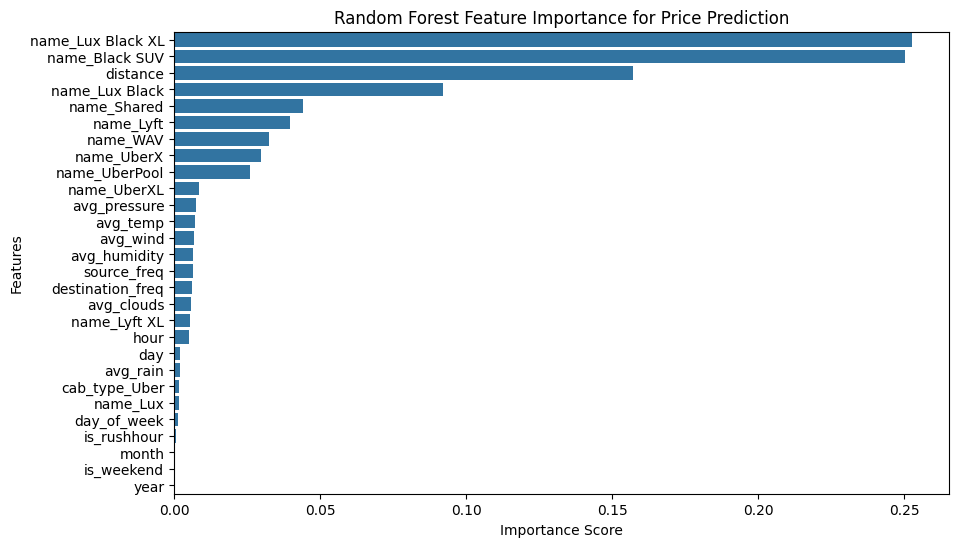

Top 5 Most Important Features for Pricing:
name_Lux Black XL    0.252684
name_Black SUV       0.250144
distance             0.157010
name_Lux Black       0.092062
name_Shared          0.044293
dtype: float64


In [116]:
feature_importance = pd.Series(rf_model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6)) 
sns.barplot(x=feature_importance.values, y=feature_importance.index) 
plt.title('Random Forest Feature Importance for Price Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show() 

print(f"Top 5 Most Important Features for Pricing:\n{feature_importance.head()}")

**ْXGBoost**

In [117]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
)

In [118]:
xgb_model.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [119]:
y_val_pred_xgb = xgb_model.predict(x_val)

In [120]:
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
r2_xgb = r2_score(y_val, y_val_pred_xgb)

mae_xgb, rmse_xgb, r2_xgb


(1.390418887641701, np.float64(2.5256040423717296), 0.9263917669692172)

In [121]:
x_final = pd.concat([x_train, x_val])
y_final = pd.concat([y_train, y_val])

In [122]:
final_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
final_xgb.fit(x_final, y_final)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [123]:
y_test_pred = final_xgb.predict(x_test)

In [124]:
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

mae_test, rmse_test, r2_test

(1.3889985593529883, np.float64(2.5329043002633544), 0.9264583354160513)

# **Surge Prediction (Classification)**

In [125]:
data_cls = cab_weather.copy()

In [126]:
data_cls.head()

,distance,surge_multiplier,price,hour,avg_temp,avg_rain,avg_clouds,avg_humidity,avg_wind,avg_pressure,year,month,day,day_of_week,is_rushhour,is_weekend,cab_type_Uber,name_Black SUV,name_Lux,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_UberPool,name_UberX,name_UberXL,name_WAV,source_freq,destination_freq
0,0.44,1.0,5.0,9,38.610833,0.000000,0.284167,0.755833,7.811667,1022.380833,2018,12,16,6,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.083306,0.082412
1,0.44,1.0,11.0,2,44.054167,0.134792,0.995000,0.898333,12.536250,1002.855417,2018,11,27,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
2,0.44,1.0,7.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2018,11,28,2,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
3,0.44,1.0,26.0,4,34.695000,0.000000,0.000000,0.712500,5.208333,1013.710000,2018,11,30,4,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412
4,0.44,1.0,9.0,3,38.011944,0.000000,0.430278,0.698889,11.085278,998.428889,2018,11,29,3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.083306,0.082412


In [127]:
data_cls['is_surge'] = (data_cls['surge_multiplier']> 1).astype(int)

In [128]:
cols_to_drop = [c for c in drop_cols if c in data_cls.columns] # drop cols may not be in data_cls (price, surge_multiplier, destination)

X = data_cls.drop(columns=cols_to_drop + ['is_surge']+ ['price', 'surge_multiplier'])
y = data_cls['is_surge']


In [129]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [130]:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(imputer.fit_transform(X_train[num_cols]))
X_val[num_cols]   = scaler.transform(imputer.transform(X_val[num_cols]))
X_test[num_cols]  = scaler.transform(imputer.transform(X_test[num_cols]))

**Baseline Model**

In [131]:
log = LogisticRegression(max_iter=1000, random_state=40, class_weight='balanced') # class_weight='balanced' to handle class imbalance
log.fit(X_train, y_train)

y_val_pred_clf= log.predict(X_val)

In [132]:
print(classification_report(y_val, y_val_pred_clf))
confusion_matrix(y_val, y_val_pred_clf)

              precision    recall  f1-score   support

           0       1.00      0.62      0.76     92550
           1       0.08      1.00      0.15      3146

    accuracy                           0.63     95696
   macro avg       0.54      0.81      0.46     95696
weighted avg       0.97      0.63      0.74     95696



array([[57078, 35472],
       [    0,  3146]])

**XGBoost**

In [133]:
# Calculate scale_pos_weight for xgboost , meaning if the model wrongly classifies positive samples, it will be penalized more heavily during training.

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight


np.float64(29.41704127503065)

In [134]:
xgb_model_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
)

In [135]:
xgb_model_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [136]:
y_val_pred = xgb_model_clf.predict(X_val)

print(classification_report(y_val, y_val_pred))
confusion_matrix(y_val, y_val_pred)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     92550
           1       0.11      0.96      0.19      3146

    accuracy                           0.74     95696
   macro avg       0.55      0.85      0.52     95696
weighted avg       0.97      0.74      0.82     95696



array([[67512, 25038],
       [  124,  3022]])

In [137]:
y_val_proba = xgb_model_clf.predict_proba(X_val)[:, 1]

threshold = 0.3
y_val_pred_custom = (y_val_proba >= threshold).astype(int)

print(classification_report(y_val, y_val_pred_custom))
confusion_matrix(y_val, y_val_pred_custom)


              precision    recall  f1-score   support

           0       1.00      0.66      0.79     92550
           1       0.09      0.99      0.17      3146

    accuracy                           0.67     95696
   macro avg       0.54      0.83      0.48     95696
weighted avg       0.97      0.67      0.77     95696



array([[61071, 31479],
       [   22,  3124]])

In [138]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)


In [139]:
X_final_cls = pd.concat([X_train, X_val])
y_final_cls = pd.concat([y_train, y_val])

final_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

final_xgb.fit(X_final_cls, y_final_cls)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [140]:
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

print(classification_report(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)


              precision    recall  f1-score   support

           0       1.00      0.66      0.79     92550
           1       0.09      1.00      0.17      3147

    accuracy                           0.67     95697
   macro avg       0.55      0.83      0.48     95697
weighted avg       0.97      0.67      0.77     95697



array([[61007, 31543],
       [   12,  3135]])

# **Shap Explanation**

### *Classification*

In [141]:
explanier = shap.Explainer(final_xgb)
shap_values = explanier.shap_values(X_train)

**Global Explanation**

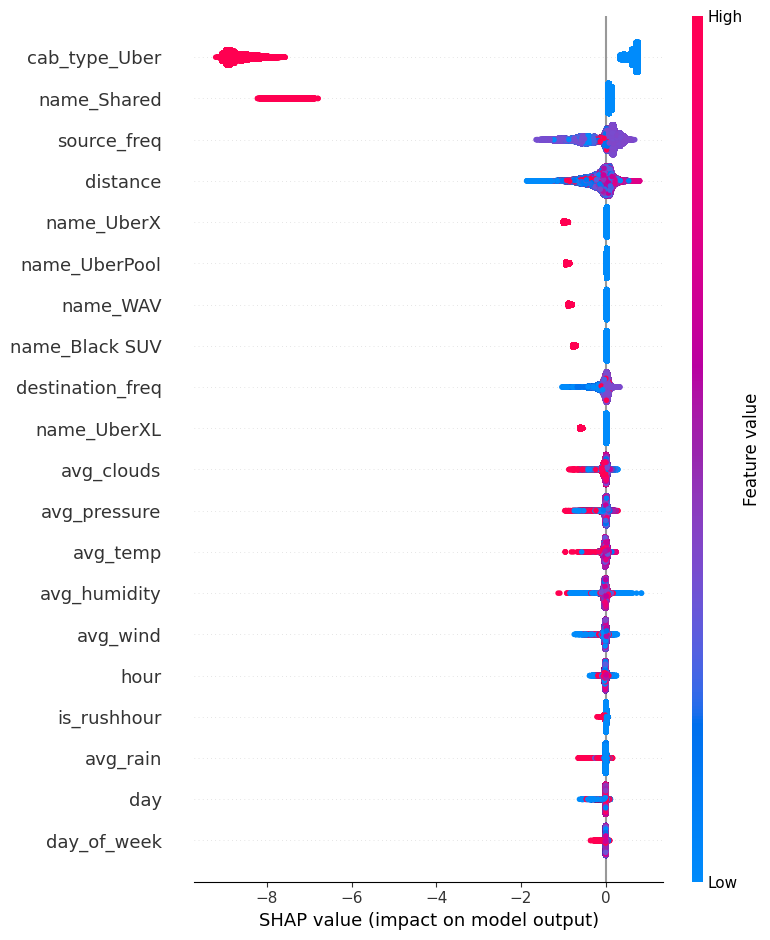

In [142]:
shap.summary_plot(shap_values, X_train)

**Local Explanatio**

In [143]:
shap.initjs()


In [144]:
i = 0
shap.force_plot(
    explanier.expected_value, shap_values[i], X_train.iloc[i]
)

### *Regression*

In [145]:
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(x_train)


### *Global Explanation*

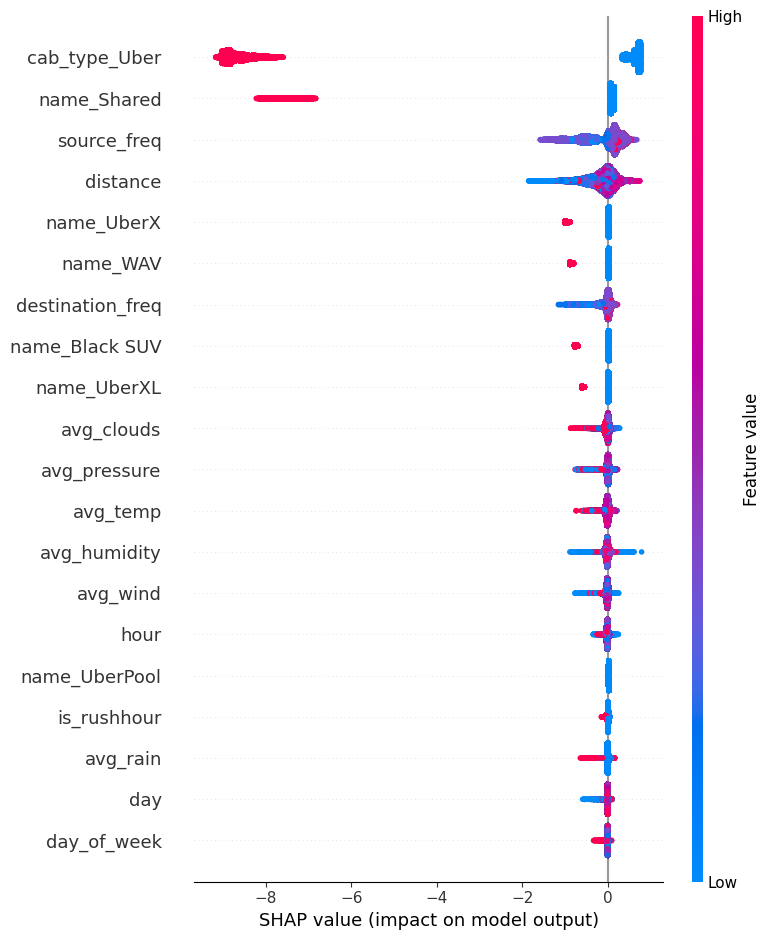

In [146]:
shap.summary_plot(shap_values, x_train)


### *Local Explanation*

In [147]:
i = 0  # أي رحلة
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_train.iloc[i]
)
